In [ ]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import rcParams
import seaborn as sns
import re
folderpath = "/home/jsw/BI/Database/sc2/"

In [ ]:
# barcode, feature, matrix 파일을 읽어서 AnnData 객체로 바꾼 후 adata_list에 저장.
import glob
import shutil
def read_10x_mtx_multiple(directory):
    # matrix, barcodes, features 파일 검색
    matrix_files = glob.glob(os.path.join(directory, '*matrix.mtx.gz'))
    barcode_files = glob.glob(os.path.join(directory, '*barcodes.tsv.gz'))
    feature_files = glob.glob(os.path.join(directory, '*features.tsv.gz'))
    feature_files += glob.glob(os.path.join(directory, '*genes.tsv.gz'))
    
    adata_list = []
    # print(matrix_files)
    
    for matrix_file in matrix_files:
        # 파일 이름에서 base_name (공통 이름) 추출
        base_name = os.path.basename(matrix_file).split('matrix')[0]
        
        # base_name 으로 barcodes, features (genes) 파일 찾기
        barcode_file = [bf for bf in barcode_files if base_name in bf]
        feature_file = [ff for ff in feature_files if base_name in ff]
        print(matrix_file, barcode_file, feature_file)
        
        if len(barcode_file) == 1 and len(feature_file) == 1:   # 만약 barcode, feature 파일이 하나씩 있는 경우
            matrix_dir = os.path.dirname(matrix_file)
            
            # 임시 디렉토리 생성 및 파일 복사
            temp_dir = os.path.join(directory, base_name + '_temp')
            os.makedirs(temp_dir, exist_ok=True)
            
            shutil.copy(matrix_file, os.path.join(temp_dir, 'matrix.mtx.gz'))
            shutil.copy(barcode_file[0], os.path.join(temp_dir, 'barcodes.tsv.gz'))
            
            if 'features' in feature_file[0]:   # features.tsv.gz 파일인 경우
                # shutil.copy(feature_file[0], os.path.join(temp_dir, 'features.tsv.gz'))
                features = pd.read_csv(feature_file[0], header = None, sep = '\t', compression = 'gzip')
                if features.shape[1] == 1: # gene name column만 있는 경우
                    features['gene_id'] = features[0]
                    features['feature_type'] = 'Gene Expression'
                    features = features[[0, 'gene_id', 'feature_type']]
                features.to_csv(os.path.join(temp_dir, 'features.tsv.gz'), header = False, index = False, sep = '\t', compression = 'gzip')
            else:   # genes.tsv.gz 파일인 경우 (type column이 없이 gene ID, gene name만 있는 경우)
                # genes.tsv.gz 파일을 features.tsv.gz 형식으로 변환
                genes = pd.read_csv(feature_file[0], header = None, sep = '\t', compression = 'gzip')
                genes['type'] = 'Gene Expression'
                genes.to_csv(os.path.join(temp_dir, 'features.tsv.gz'), header = False, index = False, sep = '\t', compression = 'gzip')
            
            # read data
            adata = sc.read_10x_mtx(
                path = temp_dir,
                var_names = 'gene_symbols',
                make_unique = True
            )
            adata.var_names_make_unique()   # gene 이름 중복 제거
            adata.obs['sample'] = base_name # sample 열 추가
            adata.obs['sample'] = adata.obs['sample'].apply(lambda x: re.search(r'_(.*?)_', x).group(1)) # 파일 이름에서 _와 _ 사이의 문자열 추출
            
            # 임시 디렉토리 및 파일 삭제
            shutil.rmtree(temp_dir)
            
            adata_list.append(adata)
        else:   # 파일이 없거나 여러개인 경우
            print(f"Could not find matching barcode of feature file for {base_name}")
            
    return adata_list

In [ ]:
adata_list = read_10x_mtx_multiple(folderpath)

adata_list

In [ ]:
len(adata_list)

# Basic filtering

In [ ]:
for adata in adata_list:
    sc.pp.filter_cells(adata, min_genes = 20)
adata_list

In [ ]:
# list of ribosommal genes
# for mouse genes
# ribo_url = 'https://www.gsea-msigdb.org/gsea/msigdb/mouse/download_geneset.jsp?geneSetName=GOCC_RIBOSOME&fileType=gmt'
# ribo_genes = pd.read_table(ribo_url, sep = '\t', header = None).transpose().drop([0, 1])

# for human genes
ribo_url = 'http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt'
ribo_genes = pd.read_table(ribo_url, skiprows = 2, header = None)

del ribo_url

In [ ]:
# Calculate QC metrics
for adata in adata_list:
    adata.var['mito'] = adata.var_names.str.startswith('MT-')   # 'mt-' for mouse, 'MT-' for human  # mitochondrial genes boolean
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)  # ribosomal genes boolean
    
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True, qc_vars=['mito', 'ribo'])    # calculate qc metrics

    # remove useless vars
    adata.obs.drop(columns=['total_counts_mito', 'total_counts_ribo'], inplace=True)
    adata.var.drop(columns=['mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'], inplace=True)

adata_list
del ribo_genes

In [ ]:
# Filter the data
for i in range(len(adata_list)):
    cutoff_top = np.quantile(adata_list[i].obs.n_genes_by_counts.values, .95)
    adata_list[i] = adata_list[i][adata_list[i].obs.n_genes_by_counts < cutoff_top]
    
    cutoff_top = np.quantile(adata_list[i].obs.total_counts.values, .95)
    adata_list[i] = adata_list[i][adata_list[i].obs.total_counts < cutoff_top]
    
    cutoff_top = np.quantile(adata_list[i].obs.pct_counts_mito.values, .90)
    adata_list[i] = adata_list[i][adata_list[i].obs.pct_counts_mito < cutoff_top]

adata_list
del cutoff_top, i

In [ ]:
# 세포가 1개 이상인 샘플만 남기기
adata_list = [adata for adata in adata_list if adata.n_obs > 0]
len(adata_list)

# Merge the data

In [ ]:
adata = sc.concat(adata_list, join = 'outer', label = 'sample', keys = [adata.obs['sample'].unique()[0] for adata in adata_list])
adata.obs.drop(columns=['n_genes_by_counts'], inplace=True)

adata.obs_names_make_unique()

# filter out genes expressed in less than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

# preserve the raw data
adata.layers['counts'] = adata.X.copy() # scVI use this data

In [ ]:
adata.write_h5ad(folderpath + 'adata_preprocessed.h5ad')

---
# Batch correction

In [3]:
adata = sc.read_h5ad(folderpath + 'adata_preprocessed.h5ad')

### Sample 나누가 Primary vs recurrent

In [ ]:
list_primary = pd.read_csv('primary.csv')['ID'].tolist()
list_recurrent = pd.read_csv('recurrent.csv')['ID'].tolist()

In [5]:
adata_primary = adata[adata.obs['sample'].isin(list_primary), :]

---
# Primary

In [6]:
# 데이터 전처리 (필요시 실행)
sc.pp.normalize_total(adata_primary, target_sum=1e4)
sc.pp.log1p(adata_primary)
sc.pp.highly_variable_genes(adata_primary, batch_key='sample', n_top_genes = 20000)
adata_primary = adata_primary[:, adata_primary.var['highly_variable']]
sc.pp.scale(adata_primary)
sc.tl.pca(adata_primary, svd_solver = 'arpack')

/home/jsw/jswenv/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/jsw/jswenv/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [7]:
# Harmony로 배치 보정
import harmonypy as hm
ho = hm.run_harmony(adata_primary.obsm['X_pca'], adata_primary.obs, 'sample', max_iter_harmony = 30)

2024-11-11 13:22:34,276 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-11 13:22:41,383 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-11 13:22:41,584 - harmonypy - INFO - Iteration 1 of 30
2024-11-11 13:22:52,510 - harmonypy - INFO - Iteration 2 of 30
2024-11-11 13:23:04,129 - harmonypy - INFO - Iteration 3 of 30
2024-11-11 13:23:15,494 - harmonypy - INFO - Iteration 4 of 30
2024-11-11 13:23:27,447 - harmonypy - INFO - Iteration 5 of 30
2024-11-11 13:23:38,715 - harmonypy - INFO - Converged after 5 iterations


In [8]:
adata_primary.obsm['X_pca'] = ho.Z_corr.T  # Harmony 보정된 PCA 결과를 저장

In [9]:
# 4. BBKNN을 사용하여 Neighbor 계산
import scanpy.external as sce
sce.pp.bbknn(adata_primary, batch_key = 'sample')

/home/jsw/jswenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-11 13:23:40.881841: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-11 13:23:40.959712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-11 13:23:40.989936: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-11 13:23:40.999511: E exte

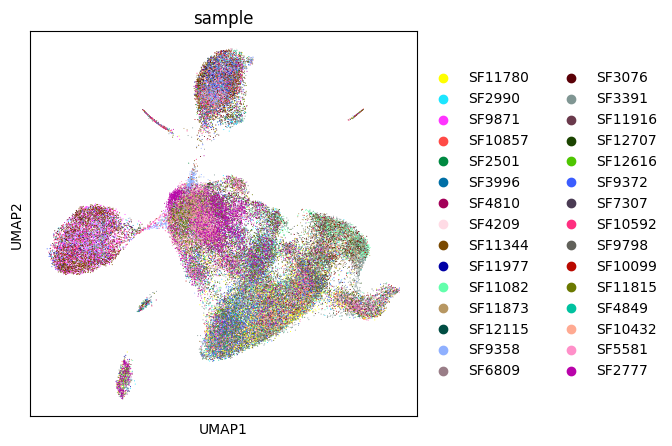

In [10]:
# UMAP 시각화
sc.tl.umap(adata_primary)
fig = sc.pl.umap(adata_primary, color='sample', return_fig=True)
fig.set_size_inches(5, 5)
plt.show()

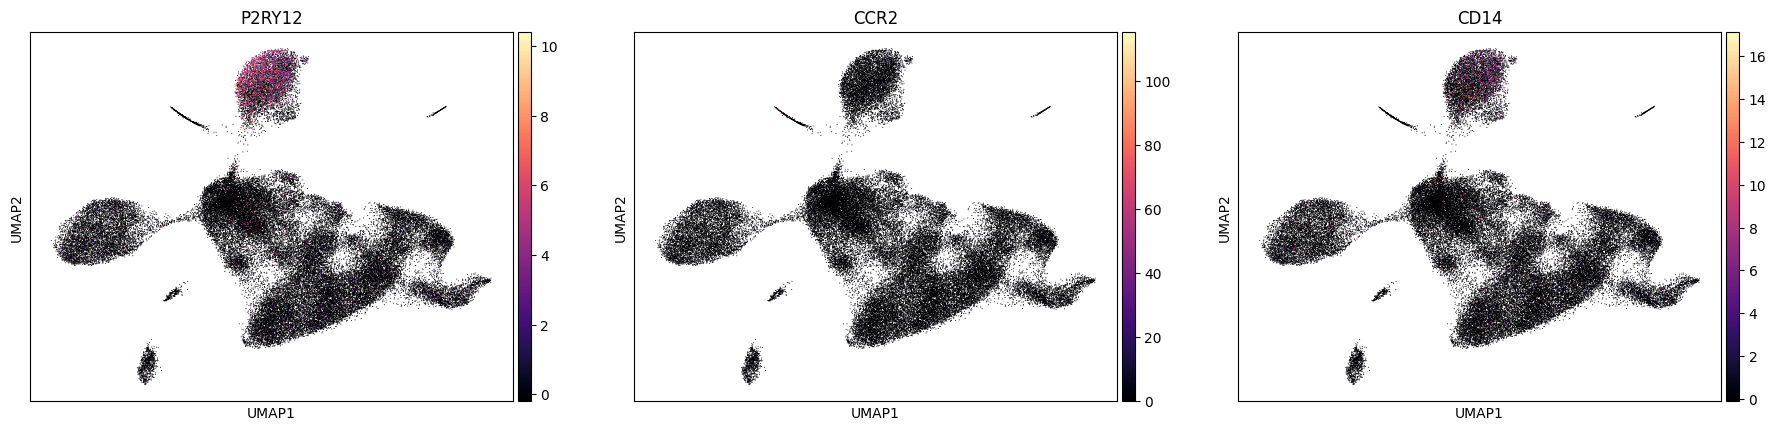

In [11]:
sc.pl.umap(
    adata_primary,
    color=['P2RY12', 'CCR2', 'CD14'],
    cmap = 'magma'
)

# 이 시점에서 sampling

In [12]:
adata_primary

AnnData object with n_obs × n_vars = 58508 × 20000
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [ ]:
# 2만개 샘플만 추출
np.random.seed(42)
adata_primary = adata_primary[np.random.choice(adata_primary.shape[0], 20000, replace=False), :]

In [15]:
# 6. Scrublet을 사용하여 Doublet 검출
import scrublet as scr
scrub = scr.Scrublet(adata_primary.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
adata_primary.obs['doublet_scores'] = doublet_scores
adata_primary.obs['predicted_doublets'] = predicted_doublets


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.62
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 3.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.5%
Elapsed time: 29.4 seconds


/tmp/ipykernel_14977/1538681484.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_primary.obs['doublet_scores'] = doublet_scores


In [20]:
adata_primary = adata_primary[~adata_primary.obs['predicted_doublets'], :]

In [21]:
adata_primary

View of AnnData object with n_obs × n_vars = 19997 × 20000
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'leiden', 'leiden_colors', 'predicted_doublets_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

/home/jsw/jswenv/lib/python3.10/site-packages/scanpy/tools/_leiden.py:197: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


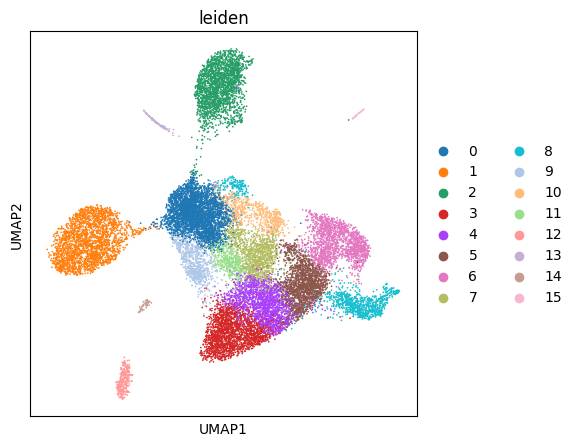

In [22]:
# leiden clustering
sc.tl.leiden(adata_primary, resolution=1)
fig = sc.pl.umap(adata_primary, color='leiden', return_fig=True)
fig.set_size_inches(5, 5)
plt.show()

In [23]:
adata_primary.write_h5ad(folderpath + 'adata_primary_preprocessed_sampled.h5ad')